In [11]:
import pymc3 as pm
import arviz as az
import theano as T
import theano.tensor as tt

import numpy as np
import matplotlib.pyplot as plt

In [37]:
tau_m = 0.01
J = -1 * tau_m

def approx_q(nu_bar,alpha_0,tau_I):
    
    #tau_I = paras['tau_I']
    #alpha_0 = paras['alpha_0']
    #nu_bar = paras['nu_bar']
    
    nu_max = 1. / (2. * np.pi * np.sqrt( tau_I * tau_m ) )
    tau_q = 2. * (tau_I + tau_m)
    q_0 = alpha_0**2 / J**2.
        
    eps = tau_q * ( nu_bar**2 + q_0 ) / ( nu_bar + 2. * tau_q * (nu_bar**2 + q_0) )
    
    q = 1. / np.sqrt( 1. + 2 * tau_q * ( nu_bar + q_0 / nu_bar ) ) * \
        ( 1. + tau_q * ( nu_bar + q_0 / nu_bar ))**( 1. - eps ) * \
        nu_max**( 2. * eps ) * nu_bar**( 2. - 2. * eps )
    
    return q

def p_nu(NU,gamma,delta,nu_max):

    return gamma / ( nu_max * np.sqrt( -np.pi * np.log( NU / nu_max ) ) ) * \
        np.exp( - delta**2/2.) * ( NU / nu_max )**(gamma**2 - 1) * \
        np.cosh( gamma * delta * np.sqrt( -2 * np.log( NU / nu_max) ) )

def logP_nu(NU,gamma,delta,nu_max):
    
    return - tt.log( nu_max / gamma * np.sqrt( -np.pi * tt.log( NU / nu_max ) ) ) - delta**2 / 2 + \
        ( gamma**2 - 1 ) * tt.log( NU / nu_max ) + \
        np.log( np.cosh( gamma * delta * np.sqrt( -2 * tt.log( NU / nu_max ) ) ) )

def logp_raw(NU,nu_bar,alpha_0,tau_I):
    
    # introduce checks for consistency, etc

    nu_max = 1. / (2. * np.pi * np.sqrt( tau_I * tau_m ) )

    q = approx_q(nu_bar,alpha_0,tau_I)

    sigma_I = np.sqrt(J**2 * nu_bar / ( 2 * tau_I ))
    sigma_V = np.sqrt(sigma_I**2 * tau_I / (tau_I + tau_m))
    alpha = np.sqrt(J**2 * q + alpha_0**2)

    selfcon_nu = nu_bar/nu_max * np.sqrt( alpha**2/sigma_V**2 + 1)
    selfcon_q = q/nu_max**2 * np.sqrt( 2*alpha**2/sigma_V**2 + 1)

    #if ((selfcon_nu < 1) and (selfcon_q < 1)):

    gamma = sigma_V / alpha

    I_0 = np.sqrt( -( alpha**2 + sigma_V**2 ) * np.log( ( nu_bar / nu_max )**2 * ( alpha**2/sigma_V**2 + 1 ) ) )
    delta = I_0 / alpha
    
    p_ = p_nu(NU,gamma,delta,nu_max)
    logP_ = logP_nu(NU,gamma,delta,nu_max)
    
    return p_, logP_

In [3]:
## create data for inference, or read from model
%cd ..
from create_measures import *
res = create_measures(L=1,S=[1,2],rerun=True)
print(res)

/home/wollex/Data/Documents/Science/WolfGroup/DarkMatter/Programme
{'rates': masked_array(
  data=[[5.38224243e-03, 9.24571477e-01, 1.28933335e+00, 1.74894160e-02],
        [5.62277173e-01, 4.61925564e-01, 3.25398331e-01, 7.26459231e-01],
        [1.55034029e-03, 1.63974308e+00, 7.12273504e-01, 1.92580477e+00],
        [3.82843490e-01, 2.08365856e-01, 2.02826657e+00, 6.12892010e-02],
        [1.96805364e-01, 1.39317766e+00, 1.88987021e-02, 1.20879603e+00],
        [4.54886448e-02, 2.99919988e-01, 1.11439394e-01, 9.66398026e-03],
        [1.22523270e+00, 2.46486035e+00, 2.60855452e+00, 4.81937407e+00],
        [5.36862806e+00, 3.78147591e-01, 1.63380704e-02, 3.52761988e-01],
        [4.38688020e-02, 2.38207343e+00, 1.30426538e+00, 8.40850648e-02],
        [1.01907064e+01, 1.16768871e+00, 1.76943143e-02, 7.63260559e-01],
        [2.98733988e+00, 3.86023012e+00, 8.85700927e-02, 4.47927163e-01],
        [1.03627666e-02, 3.40058369e-01, 5.14963354e-01, 5.55141152e-02],
        [1.18467882e-

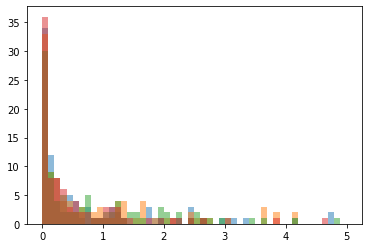

In [47]:
NU = np.squeeze(res['rates_T'])
#NU[NU==0] = 0.001
groups = np.array([len(rates)*[i] for i,rates in enumerate(NU.T)]).flatten()

n = NU.shape[1] # number of distinct tuples of (animals, hemispheres, layers)
obs_nu_bar = np.mean(NU,axis=0)   # should have 

for i in range(n):
    plt.hist(NU[:,i],np.linspace(0,5,51),alpha=0.5)
    
plt.show()

In [18]:
nnn = NU.flatten()
np.min(NU)

0.0

In [20]:
NU[groups]

masked_array(
  data=[[0.005     , 0.90166667, 1.225     , 0.015     ],
        [0.005     , 0.90166667, 1.225     , 0.015     ],
        [0.005     , 0.90166667, 1.225     , 0.015     ],
        ...,
        [0.43      , 0.21333333, 1.985     , 0.065     ],
        [0.43      , 0.21333333, 1.985     , 0.065     ],
        [0.43      , 0.21333333, 1.985     , 0.065     ]],
  mask=False,
  fill_value=1e+20)

In [51]:
with pm.Model() as model:
    # replace normals with student-t distributions
    mu_alpha_0 = pm.HalfStudentT('mu_alpha_0',sigma=0.01,nu=1.);
    sigma_alpha_0 = pm.HalfStudentT('sigma_alpha_0',sigma=0.02,nu=1.);
    
    alpha_0 = pm.HalfStudentT('alpha_0',sigma=mu_alpha_0,nu=sigma_alpha_0,shape=n);
    
    
    nu_bar = pm.Normal('nu_bar',obs_nu_bar,0.1,shape=n);
    
    
    mu_tau_I = pm.HalfNormal('mu_tau_I',sigma=0.01);
    sigma_tau_I = pm.HalfNormal('sigma_tau_I',sigma=0.01);
    
    tau_I = pm.TruncatedNormal('tau_I',mu=mu_tau_I,sigma=sigma_tau_I,lower=0.,upper=0.1,shape=n);
    
    
    def likelihood(NU):
        # introduce checks for consistency, etc
        
        nu_max = 1. / (2. * np.pi * np.sqrt( tau_I * tau_m ) )
        
        q = approx_q(nu_bar,alpha_0,tau_I)
        
        sigma_I = np.sqrt(J**2 * nu_bar / ( 2 * tau_I ))
        sigma_V = np.sqrt(sigma_I**2 * tau_I / (tau_I + tau_m))
        alpha = np.sqrt(J**2 * q + alpha_0**2)
        
        selfcon_nu = nu_bar/nu_max * np.sqrt( alpha**2/sigma_V**2 + 1)
        selfcon_q = q/nu_max**2 * np.sqrt( 2*alpha**2/sigma_V**2 + 1)
        
        #if ((selfcon_nu < 1) and (selfcon_q < 1)):

        gamma = sigma_V / alpha

        I_0 = np.sqrt( -( alpha**2 + sigma_V**2 ) * np.log( ( nu_bar / nu_max )**2 * ( alpha**2/sigma_V**2 + 1 ) ) )
        delta = I_0 / alpha
        
        tt.printing.Print('nu_bar')(nu_bar)
        tt.printing.Print('mu_alpha_0')(mu_alpha_0)
        tt.printing.Print('sigma_alpha_0')(sigma_alpha_0)
        tt.printing.Print('alpha_0')(alpha_0)
        tt.printing.Print('mu_tau_I')(mu_tau_I)
        tt.printing.Print('sigma_tau_I')(sigma_tau_I)
        tt.printing.Print('tau_I')(tau_I)

        logP_ = logP_nu(NU,gamma,delta,nu_max)
        logP_ = tt.switch(tt.isnan(logP_), 0., logP_)
        tt.printing.Print('logP_')(tt.sum(logP_))
        return tt.sum(logP_)
        #p_ = p_nu(NU,gamma,delta,nu_max)
        #p_ = tt.switch(tt.isnan(p_), 0., p_)
        #tt.printing.Print('p_')(tt.prod(p_))
        #return tt.prod(p_)
        
        
        #logP_sum = np.nansum(logP_)
            #if np.isnan(logP_sum):
            #    logP_sum = -1000
        #    return logP_sum
        #else:
        #    return -1000
       
        # return logp_
    
    logP = pm.DensityDist('logP',likelihood,observed=NU)
                   
    trace = pm.sample(init='adapt_diag',return_inferencedata=True)

nu_bar __str__ = [1.02511667 0.97316667 1.2619     1.19695   ]
mu_alpha_0 __str__ = 0.010000000000000004
sigma_alpha_0 __str__ = 0.02
alpha_0 __str__ = [0.01 0.01 0.01 0.01]
mu_tau_I __str__ = 0.007978845608028655
sigma_tau_I __str__ = 0.007978845608028655
tau_I __str__ = [0.05 0.05 0.05 0.05]
logP_ __str__ = -353.9757541574604
nu_bar __str__ = [1.02511667 0.97316667 1.2619     1.19695   ]
mu_alpha_0 __str__ = 0.010000000000000004
sigma_alpha_0 __str__ = 0.02
alpha_0 __str__ = [0.01 0.01 0.01 0.01]
mu_tau_I __str__ = 0.007978845608028655
sigma_tau_I __str__ = 0.007978845608028655
tau_I __str__ = [0.05 0.05 0.05 0.05]


/tmp/ipykernel_27239/863341602.py:30: RuntimeWarning: invalid value encountered in sqrt
  return - tt.log( nu_max / gamma * np.sqrt( -np.pi * tt.log( NU / nu_max ) ) ) - delta**2 / 2 + \
/tmp/ipykernel_27239/863341602.py:32: RuntimeWarning: invalid value encountered in sqrt
  np.log( np.cosh( gamma * delta * np.sqrt( -2 * tt.log( NU / nu_max ) ) ) )


logP_ __str__ = -353.9757541574604
nu_bar __str__ = [1.02511667 0.97316667 1.2619     1.19695   ]
mu_alpha_0 __str__ = 0.010000000000000004
sigma_alpha_0 __str__ = 0.02
alpha_0 __str__ = [0.01 0.01 0.01 0.01]
mu_tau_I __str__ = 0.007978845608028655
sigma_tau_I __str__ = 0.007978845608028655
tau_I __str__ = [0.05 0.05 0.05 0.05]
logP_ __str__ = -353.9757541574604


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau_I, sigma_tau_I, mu_tau_I, nu_bar, alpha_0, sigma_alpha_0, mu_alpha_0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 24 seconds.
There were 107 divergences after tuning. Increase `target_accept` or reparameterize.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5929150856278769, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [50]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

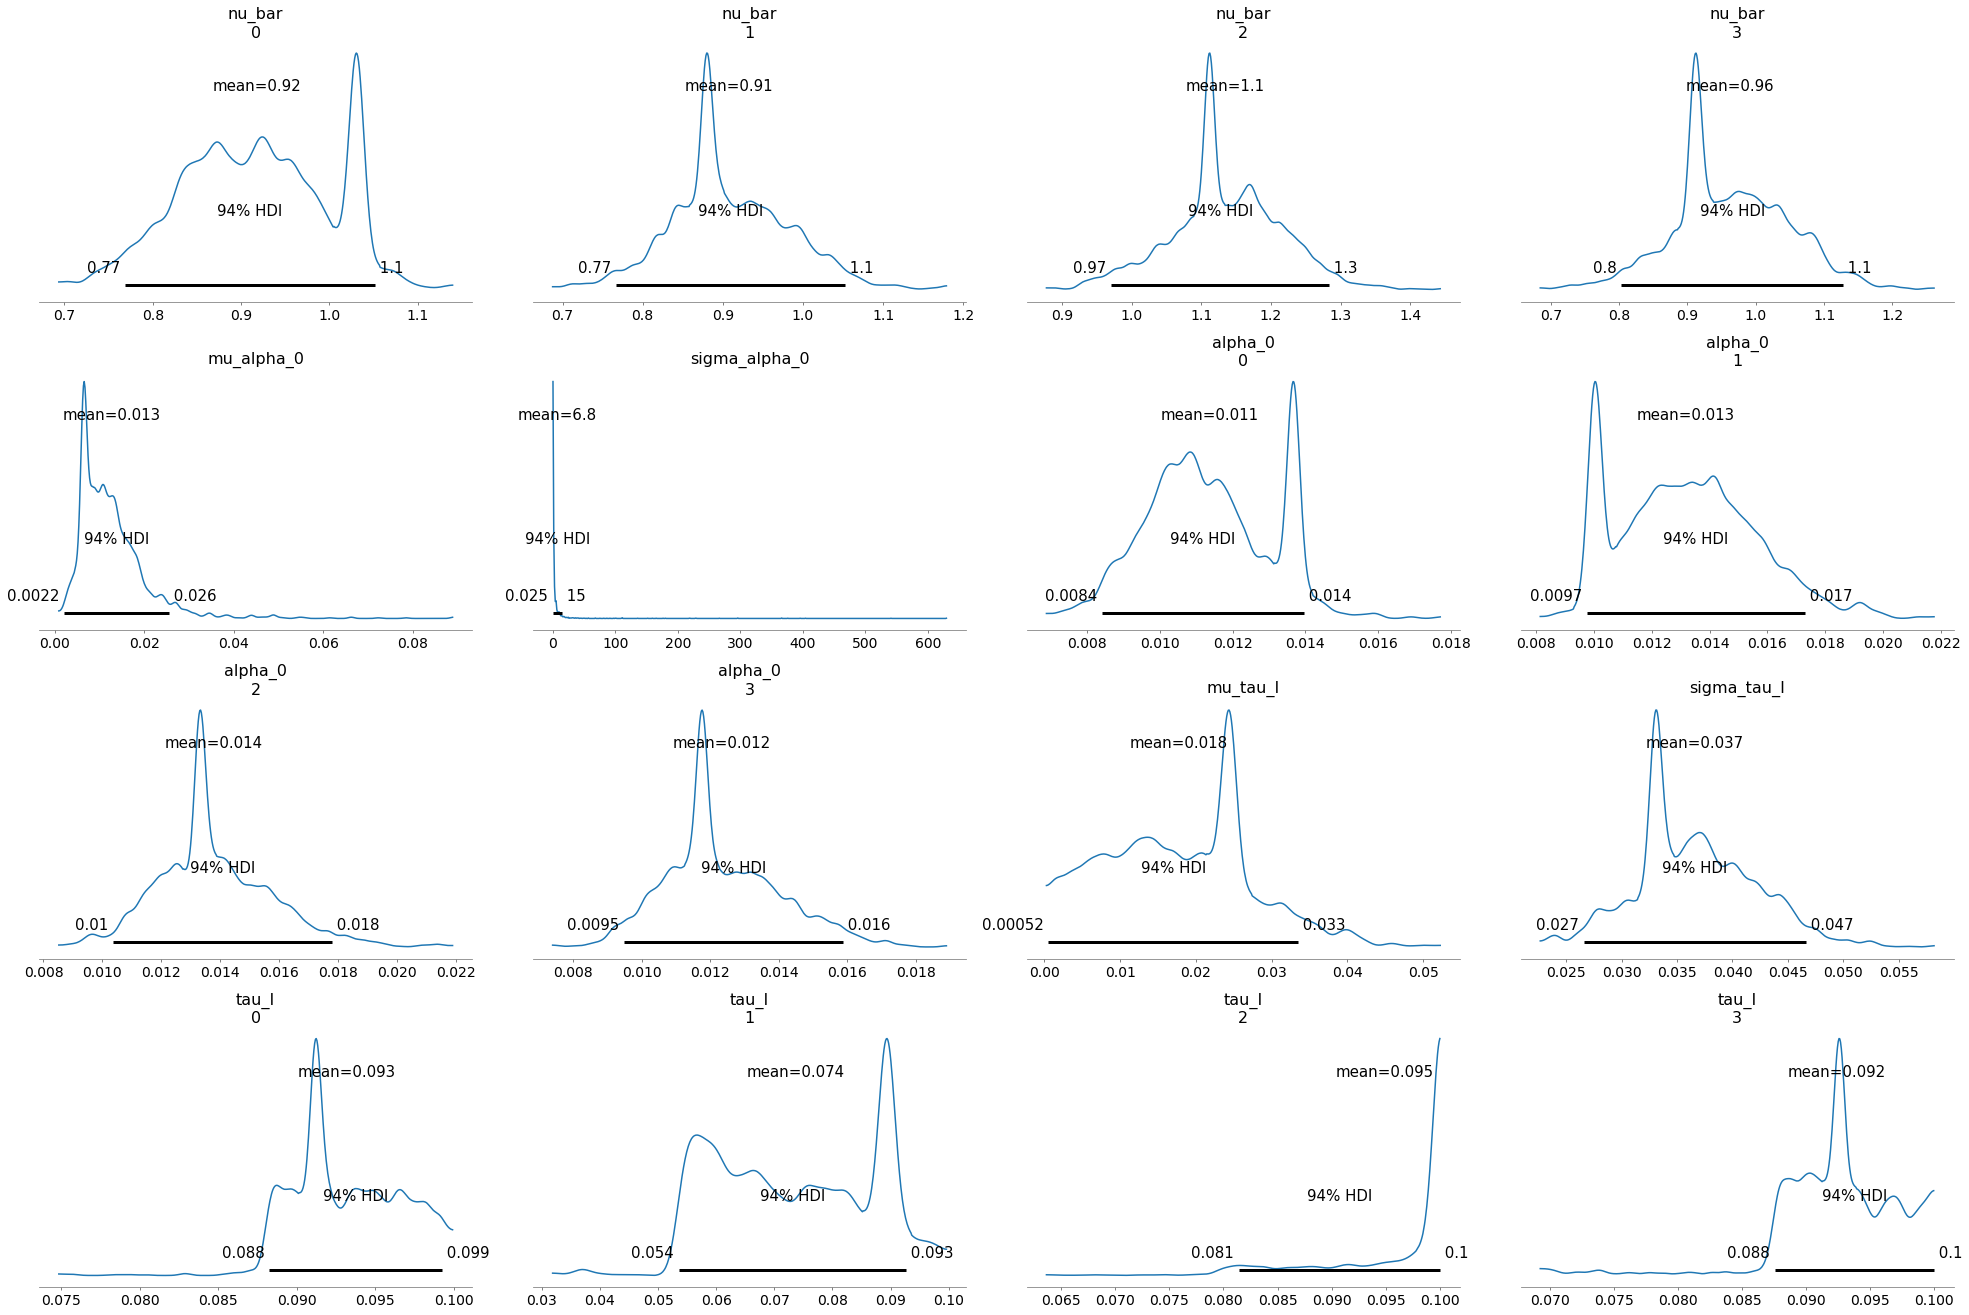

In [52]:
az.plot_posterior(trace)
plt.tight_layout()


In [ ]:
nu = np.linspace(0.,2.,101)
plt.plot(nu,approx_q({'tau_I': 0.005, 'alpha_0': 0.04, 'nu_bar': nu}))
plt.plot(nu,nu**2,'r--')
plt.show()

In [ ]:
nu = np.linspace(0.1,10.,100)
p, log = logp_raw(nu,2.,0.02,0.005)
plt.plot(nu,p)
